<a href="https://colab.research.google.com/github/ZiyueNie/19ma573ZiyueNie/blob/master/src/hw4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The objective is to get familiar with model calibration.
- download  today's call option prices of your favorite stock with maturity $T_1$ and several near the money strikes $(K_1, \ldots, K_n)$.
- compute IV with your bsm price engine for each option price. You are going to use USD Libor 3-month for your interest rate input. 
- plot a figure of strike v.s. IV. Do you find any volatility smile? 
- calibrate bsm volatility for the option prices, denote it by $\hat \sigma$. You may use any error function for the calibration purpose.
- reproduce option prices using your price engine with calibrated volatility, then compare how close they are to the market prices.


In [3]:
!git clone https://github.com/ZiyueNie/19ma573ZiyueNie

Cloning into '19ma573ZiyueNie'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 212 (delta 19), reused 0 (delta 0), pack-reused 155
Receiving objects: 100% (212/212), 333.88 KiB | 9.54 MiB/s, done.
Resolving deltas: 100% (80/80), done.


In [4]:
cd 19ma573ZiyueNie/src/

/content/19ma573ZiyueNie/src


In [0]:
from european_options import VanillaOption
from gbm import Gbm

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as so
import pandas as pd
import math


In [7]:
'''======
Read data
========='''
#Read four-column data
#columns are otype, maturity, strike, option_price
call_option_data1 = pd.read_csv('SBUX_call.csv')

print('>>>>>>Starbucks_call data')
print(call_option_data1)

>>>>>>Starbucks_call data
          Contract Name         Last Trade Date  Strike  Last Price  Bid  Ask  \
0   SBUX190315C00050000  2019-02-04 10:17AM EST    50.0       17.38    0    0   
1   SBUX190315C00052500   2019-01-25 9:30AM EST    52.5       14.67    0    0   
2   SBUX190315C00055000   2019-02-04 2:21PM EST    55.0       12.46    0    0   
3   SBUX190315C00057500   2019-01-25 3:50PM EST    57.5        9.50    0    0   
4   SBUX190315C00060000   2019-02-04 2:28PM EST    60.0        7.52    0    0   
5   SBUX190315C00062500  2019-02-04 12:35PM EST    62.5        4.92    0    0   
6   SBUX190315C00065000   2019-02-04 3:56PM EST    65.0        3.15    0    0   
7   SBUX190315C00067500   2019-02-04 3:52PM EST    67.5        1.48    0    0   
8   SBUX190315C00070000   2019-02-04 3:55PM EST    70.0        0.55    0    0   
9   SBUX190315C00072500   2019-02-04 3:58PM EST    72.5        0.14    0    0   
10  SBUX190315C00075000   2019-02-04 3:19PM EST    75.0        0.04    0    0   
11

In [8]:
data2 = call_option_data1.drop(['Contract Name','Last Trade Date','Bid','Ask','Change','% Change', 'Volume','Open Interest', 'Implied Volatility'], axis=1,inplace=False) 
print(data2)


    Strike  Last Price
0     50.0       17.38
1     52.5       14.67
2     55.0       12.46
3     57.5        9.50
4     60.0        7.52
5     62.5        4.92
6     65.0        3.15
7     67.5        1.48
8     70.0        0.55
9     72.5        0.14
10    75.0        0.04
11    80.0        0.03


In [9]:
'''=========
Tips for time length
============='''

today = np.datetime64('2019-02-04')
maturity = np.datetime64('2019-06-21')
time_to_maturity_days = maturity - today

time_to_maturity_years = time_to_maturity_days/np.timedelta64(1,'D')/365
T_1=time_to_maturity_years 
print('--->>>>>time to maturity in years is ' + str(time_to_maturity_years))

--->>>>>time to maturity in years is 0.37534246575342467


In [0]:
'''==============
below are from the market data for underlying process
================='''
Int_rates=2.73263/100.0   #3 month US Dollar LIBOR interest rate
gbm1 = Gbm(
    init_state = 67.58, #today's starbucks stock price
    drift_ratio =Int_rates, 
    vol_ratio = .1 #initial guess
)

In [0]:
option_list = []
#for i in range(len(data2['Strike'])):
for i in range(len(call_option_data1['Strike'])):
    option1= VanillaOption(
      otype = 1,
     strike = call_option_data1['Strike'][i], 
      maturity = T_1,
      market_price=call_option_data1['Last Price'][i] 
      )
    option_list.append(option1)

In [0]:
'''================
define an error function
===================='''
def error_function(vol, gbm, option):
  gbm.vol_ratio = vol
  return np.abs(option.market_price - gbm.bsm_price(option))

'''==========
define a method to seek for an implied volatility
============'''

def implied_volatility(gbm, option):
  init_vol = .1 #initial guess
  return so.fmin(error_function, init_vol, args = (gbm, option), disp = 0)[0]

In [13]:
data3=[]
for i in range(len(call_option_data1['Strike'])):
  a = implied_volatility(gbm1, option_list[i])
  data3.append(a)
print(data3)
#data2=data2.append(data3)



[0.0500000000000001, 0.0500000000000001, 0.030000000000000138, 0.03500000000000013, 0.010000000000000175, 0.010000000000000175, 1.942890293094024e-16, 0.06401367187500008, 0.07279296875000006, 0.07447265625000005, 0.08117187500000005, 0.12007812500000006]


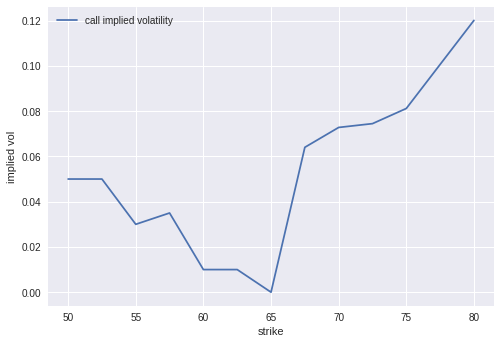

In [14]:
plt.plot(call_option_data1['Strike'],data3,label='call implied volatility')
plt.ylabel('implied vol')
plt.xlabel('strike')
plt.legend()

In [0]:

'''==========
define a method for error function
============'''

def error_function(vol, gbm, option_list):
  gbm.vol_ratio = vol
  err1 = 0
  for i in np.arange(len(option_list)):
    err1 = err1 + ((option_list[i]).market_price - gbm.bsm_price(option_list[i]))**2    
  return err1

In [0]:
'''==========
define a method to seek for a calibrated volatility
============'''

def bsm_calibration(gbm, option_list):
  init_vol = .1 #initial guess
  return so.fmin(error_function, init_vol, args = (gbm, option_list), disp = 0)[0]

In [19]:

# Take options of 2-mon maturity
filter1 = list(filter(lambda x: x.maturity == T_1, option_list))
calibrated_volatility1 = bsm_calibration(gbm1, filter1)
print('>>>>>>>> calibrated_volatility is ' + str(calibrated_volatility1))

>>>>>>>> calibrated_volatility is 0.06296875000000007


In [20]:
gbm1.vol_ratio = calibrated_volatility1

#find calibrated option price
filter1_calibrated_price = [gbm1.bsm_price(filter1[i]) for i in range(len(filter1))]
print('>>>>>>>>> this is option price calculated from calibrated vol')
filter1_calibrated_price

>>>>>>>>> this is option price calculated from calibrated vol


[18.090215001788927,
 15.61572575187995,
 13.141236506069397,
 10.66674934100805,
 8.19251521515406,
 5.727129971203517,
 3.365405662272842,
 1.4636371172167486,
 0.4127476710428333,
 0.0692431036642942,
 0.006694378604421569,
 1.2454327980043365e-05]

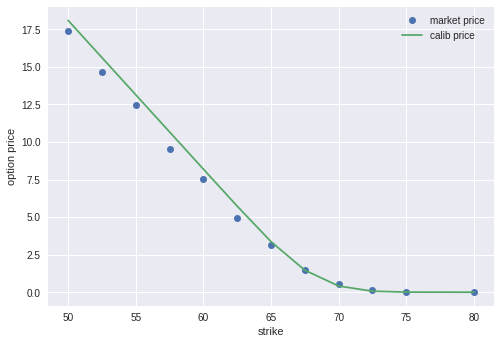

In [22]:

x_co = [filter1[i].strike for i in range(len(filter1))]
y_co = [filter1[i].market_price for i in range(len(filter1))]
plt.plot(x_co, y_co, 'o', label='market price')

y_co = filter1_calibrated_price
plt.plot(x_co, y_co, label = 'calib price')

plt.ylabel('option price')
plt.xlabel('strike')
plt.legend();